In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

# Global variables
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
start_year = 1993
curr_year = datetime.now().year

In [2]:
# Custom API
from sys import path

path.append('../API/eda')
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot

path.append('../API/fetch')
import data_fetch as fetch

path.append('../API/model')
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, model_predictions, get_classification_report

path.append('../API/preprocess')
from feature_engineering import create_bracket_winners
from data_integrity import season_team_to_coach_team_dict, curr_season_to_tourney_dict
from data_clean import clean_basic_stats, clean_tourney_data
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline

# Data Fetching

## Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

# Data Pipeline

Below is the output of a merge of the datasets displayed above (after they've been cleaned). Once we remove the features with nulls that won't be imputed, we can begin our exploratory data analysis (EDA).

## Examples

Previous years permitted the provision of examples as to how the predictors listed above were scraped. However, due to request rate limit restrictions from SportsReference, the inclusion of these examples in the research notebook has been discontinued. Please refer to the Python API for examples moving forward.

## Tournament Games Dataset

In [3]:
# Check if the historical data CSV exists, if it doesn't then create it
prev_year = curr_year-1

try:
    mm_matchups_df = pd.read_csv(f'{curr_year}_march_madness_hist_data.csv')
except FileNotFoundError:
    hist_matchups_df = pd.read_csv(f'../{prev_year}/{prev_year}_march_madness_hist_data.csv')
    curr_matchups_df = dataset_pipeline([prev_year])
    
    mm_matchups_df = pd.concat([hist_matchups_df, curr_matchups_df])
    mm_matchups_df.to_csv(f'{curr_year}_march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,G_Favorite,W_Favorite,W-L%_Favorite,...,eFG%_Underdog,TOV%_Underdog,ORB%_Underdog,FT/FGA_Underdog,Conf_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,1993,First Round,1,UNC,16,East Carolina,0,38.0,34.0,0.895,...,0.465,17.3,NaN,0.248,CAA,0.0,1.0,0.0,0.0,0.0
1,1993,Second Round,1,UNC,8,Rhode Island,1,38.0,34.0,0.895,...,0.484,16.4,NaN,0.324,A-10,0.0,1.0,0.0,0.0,0.0
2,1993,Sweet Sixteen,1,UNC,4,Arkansas,0,38.0,34.0,0.895,...,0.539,15.9,NaN,0.243,SEC,1.0,9.0,3.0,1.0,0.0
3,1993,Elite Eight,1,UNC,2,Cincinnati,0,38.0,34.0,0.895,...,0.512,16.9,NaN,0.222,GMWC,1.0,3.0,2.0,1.0,0.0
4,1993,Final Four,1,UNC,2,Kansas,0,38.0,34.0,0.895,...,0.565,17.0,NaN,0.280,Big 8,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,2022,First Round,3,Texas Tech,14,Montana State,0,37.0,27.0,0.730,...,0.541,16.3,27.3,0.289,Big Sky,0.0,1.0,0.0,0.0,0.0
1873,2022,First Round,7,Michigan State,10,Davidson,0,36.0,23.0,0.639,...,0.561,13.3,23.8,0.238,A-10,0.0,10.0,1.0,0.0,0.0
1874,2022,First Round,2,Duke,15,Cal State Fullerton,0,39.0,32.0,0.821,...,0.494,15.7,29.7,0.269,Big West,0.0,2.0,0.0,0.0,0.0
1875,2022,Second Round,2,Duke,7,Michigan State,0,39.0,32.0,0.821,...,0.520,16.3,30.7,0.224,Big Ten,0.0,24.0,14.0,8.0,1.0


## Handling Missing Values

### Finding the Nulls

Recall that our cleaned dataset has a total of 1,814 March Madness games present, and each March Madness will consist of no more than 67 games (4 play-in games + 63 tournament games). As can be seen below, the advanced stats pertaining to personal fouls (PF) and turnovers (TOV) are the only features listed with no more than a season's worth of missing data. Given how rapidly the gameplay of college basketball has evolved over the time horizon of our dataset, imputing nulls on multiple years of March Madness data would likely be a futile effort. The features with a high volume of nulls (1> season) will be dropped from the dataset.

In [4]:
# Given that a feature has any nulls, find the number of nulls present
true_nulls = fetch.get_feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog      1072
Pace_Favorite      1065
ORB%_Favorite       766
ORtg_Favorite       766
STL%_Favorite       766
STL%_Underdog       765
ORtg_Underdog       765
ORB%_Underdog       764
Away_L_Underdog     504
Away_W_Underdog     504
Away_L_Favorite     504
Home_L_Underdog     504
Home_W_Underdog     504
Away_W_Favorite     504
Home_L_Favorite     504
Home_W_Favorite     504
ORB_Underdog        255
ORB_Favorite        254
PF_Underdog          64
PF_Favorite          64
TOV_Underdog          3
TOV%_Underdog         3
TOV_Favorite          1
TOV%_Favorite         1
dtype: int64

In [5]:
# Get turnover features from true_nulls
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]

# Get personal foul features from true_nulls
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

# All other features found in true_nulls are dropped from our original dataset
null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [6]:
# View the rows containing all of the dataset's nulls to be imputed
# This will be a useful reference to validate the proper imputation of the nulls
tov_nulls_rows = fetch.get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = fetch.get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV_Underdog,TOV%_Underdog,TOV_Favorite,TOV%_Favorite,Underdog_Upset
51,1993,NaN,NaN,561.0,17.4,0
52,1993,NaN,NaN,373.0,15.9,1
56,1993,552.0,16.6,NaN,NaN,0
483,2000,NaN,NaN,520.0,17.8,0


,Year,PF_Underdog,PF_Favorite,Underdog_Upset
568,2002,NaN,NaN,1
569,2002,NaN,NaN,0
570,2002,NaN,NaN,0
571,2002,NaN,NaN,0
572,2002,NaN,NaN,0
...,...,...,...,...
627,2002,NaN,NaN,0
628,2002,NaN,NaN,0
629,2002,NaN,NaN,0
630,2002,NaN,NaN,0


(None, None)

### What are the Distributions of the Features We Wish to Impute?

Upon looking at the distributions below of all turnover and personal foul features, we can see that they closely resemble a normal distribution. Given this assumption, the features' means will serve as good values for imputing the nulls.

1993 feature distributions
2000 feature distributions


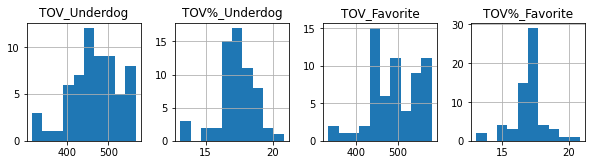

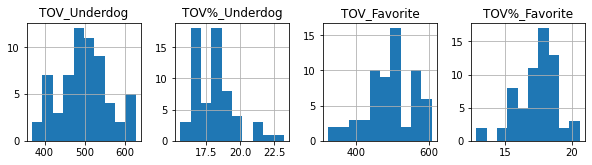

In [7]:
# View the distributions of the dataset's turnover features
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF_Underdog'}>,
        <AxesSubplot:title={'center':'PF_Favorite'}>]], dtype=object)

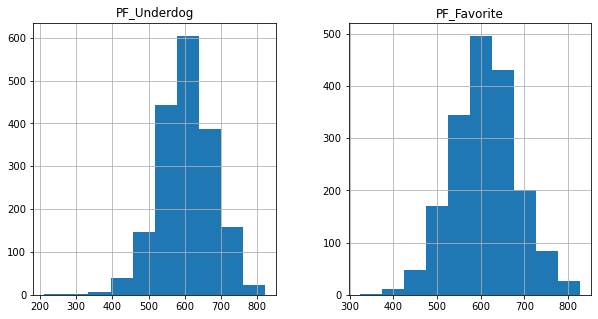

In [8]:
# View the distributions of the dataset's personal foul features
pf_null_years = sorted(list(set(pf_nulls_rows['Year'])))

mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season & Target Variable

In [9]:
# Retrieve TOV feature means by season; only include seasons that contain nulls
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby(['Year', 'Underdog_Upset']).mean()
tov_col_means.loc[tov_null_years]

TOV_Underdog  TOV%_Underdog  TOV_Favorite  TOV%_Favorite
Year Underdog_Upset                                                          
1993 0                 463.044444      17.360000    496.666667      16.984444
     1                 475.937500      17.056250    481.941176      17.282353
2000 0                 492.704545      18.336364    507.733333      17.511111
     1                 511.000000      17.544444    468.944444      17.066667

In [10]:
for year in tov_null_years:
    for label in [0, 1]:
        for col in tov_null_fills:
            # Get feature's rows with nulls for given year & label type
            fill_condition = (tov_nulls_rows['Year'] == year) & (tov_nulls_rows['Underdog_Upset'] == label)
            col_fill_rows = tov_nulls_rows[fill_condition].index
            # Get feature's mean for given year
            col_year_mean = np.round(tov_col_means.loc[(year, label), col], 1)
            # Impute nulls of interest
            mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)

# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV_Underdog,TOV%_Underdog,TOV_Favorite,TOV%_Favorite
51,463.0,17.4,561.0,17.4
52,475.9,17.1,373.0,15.9
56,552.0,16.6,496.7,17.0
483,492.7,18.3,520.0,17.8


### Impute PF Nulls by Target Variable Using Entire Distribution

In [11]:
# Retrieve PF feature means; only found in one season
pf_col_means = mm_matchups_df[pf_nulls_rows.columns].groupby(['Underdog_Upset']).mean()
pf_col_means.drop('Year', axis=1)

,PF_Underdog,PF_Favorite
Underdog_Upset,,
0,595.699357,616.576367
1,618.871705,594.926186


In [12]:
for label in [0, 1]:
    for col in pf_null_fills:
        # Get feature's rows with nulls for given year & label type
        fill_condition = (pf_nulls_rows['Underdog_Upset'] == label)
        col_fill_rows = pf_nulls_rows[fill_condition].index
        # Get feature's mean
        col_mean = np.round(pf_col_means.loc[label, col], 1)
        # Impute nulls of interest
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_mean)
    
# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF_Underdog,PF_Favorite
568,618.9,594.9
569,595.7,616.6
570,595.7,616.6
571,595.7,616.6
572,595.7,616.6
...,...,...
627,595.7,616.6
628,595.7,616.6
629,595.7,616.6
630,595.7,616.6


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA:
 - What is our bracket's accuracy if we guess the favorite always wins?
 - How often do upsets occur in a given year's March Madness?
 - What is the distribution of upsets across the tournament rounds?
 - Which seeding combinations are most likely to produce upsets?

## What is our Bracket's Accuracy if We Guess the Favorite Always Wins?

This is a strategy many of us have employed at least once while filling out a March Madness bracket, myself included. This is a classic EDA question which explores the idea of the base rate: historically, how often would we be right if we always assumed the favorite won the March Madness matchup? ~68.6% of our predictions would be correct according to our data, approximately 2 out of every 3 games. This means that for any model to be of value to us, it must demonstrate >68.7% of its predictions are correct.

In college basketball, the best (and thus most impactful) players typically leave the NCAA after no more than 2 years. Thus, a 2-year moving average was chosen to illustrate the base rate's trends as new impactful players participate in March Madness. Our base rate is maintained fairly consistently over time, with a few exceptions scattered across the dataset's time horizon.

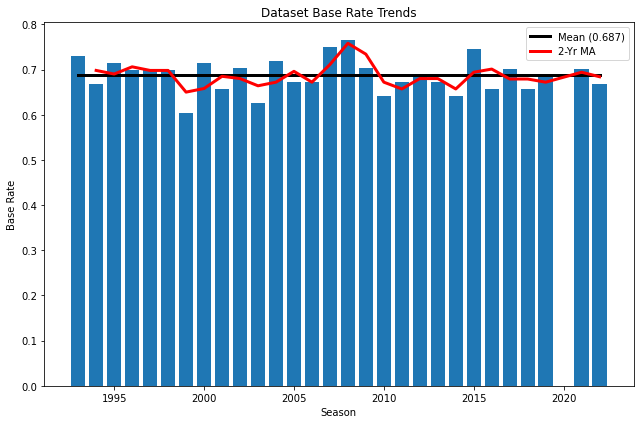

In [13]:
# Each season's base rate
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
# Dataset's mean base rate
mean_base_rate = np.round(yearly_base_rates.mean(), 3)
# Moving average
years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness?

If favorites win March Madness matchups ~68.7% of the time, then we can conclude the underdogs are winning the other 31.3%; this translates to approximately 20 upsets per year. This knowledge gives us insight into how many upsets we should expect our model to predict (i.e. 25 is likely too high, 15 is likely too low).

A 2-year moving average has been employed once again to highlight the trends present across the dataset's time horizon. At first it may appear to be more volatile than the base rate trends, but this is simply due to the scale of the y-axis.

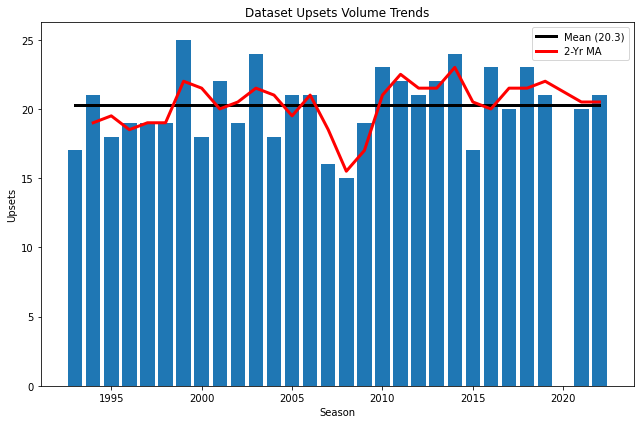

In [14]:
# Each season's upset count
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': 'sum'})
# Dataset's mean upset count
mean_upsets = np.round(yearly_upsets['Underdog_Upset'].mean(), 1)
# Moving average
upsets_ma = np.round(yearly_upsets.rolling(years_ma).mean(), 1)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_upsets.index, [mean_upsets] * len(yearly_upsets), color='k', linewidth=3, label=f'Mean ({mean_upsets})')
plt.plot(yearly_upsets.index, upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_upsets.index, yearly_upsets['Underdog_Upset'])

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets')

## What is the Distribution of Upsets Across the Tournament Rounds?

Of the 20 upsets that we can expect in any given March Madness, the visualization below gives us an idea of how many upsets we can expect in each round. Nearly 70% of all upsets happen in the first 2 rounds, which is sensible given that 75% of all games are held in the first 2 rounds. Fewer upsets in each successive round is expected not only because of a diminished volume of games, but also a greater saturation of top-tier teams amongst the remaining teams in contention. We should expect our model to follow a similar pattern.

In [15]:
# Retrieve data about March Madness matchup seed pairings
seed_pairs = get_seed_pairs(mm_matchups_df)
# Extract seed pairs that resulted in upsets
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]

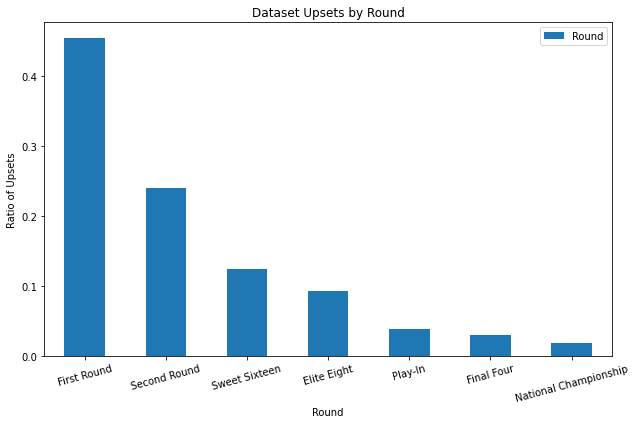

In [16]:
# Group upset seed pairs by round and count them
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

Suppose our model predicts 12 upsets in the first round, even though we should only expect 9 according to our EDA. In the event this type of situation arises, it'd be valuable to know which seed pairings are most likely to produce upsets so we could discard 3 of the 12 first round upsets with the lowest upset likelihoods.

Only the top 25 upset likelihoods are shown because our EDA also revealed we should expect no more than 25 upsets in a given year. We can see once again that the overwhelming majority of upsets occur in the first round, particularly in the 4 seed pairings that are the most evenly matched (Seeds 8 vs. 9 through Seeds 5 vs. 12). Our model should emulate this behavior fairly closely in its upset predictions.

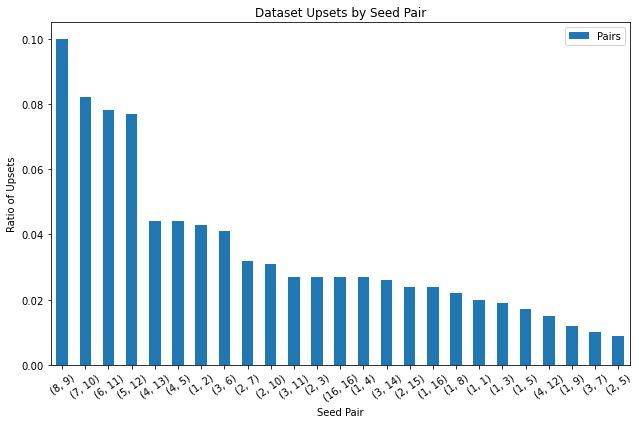

In [17]:
# Group upsets by seed pairing and count them
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

# Feature Engineering & Analysis

Below we can see our original feature matrix (X) and then our feature matrix prepped for model fitting (prep_all_X). This transformation is performed by passing X through the feature pipeline. 

One of the primary actions that transpires in the pipeline is subtracting the favorites' stats from the underdogs' stats in each matchups to create underdog relative features. This not only retains virtually all of our potential information gain, but also improves computation speed and reduces the likelihood of the model overfitting the data.

The second primary action is the scaling of our numerical features. This conversion of all numerical features to a normal distribution is important because it eliminates the possibility of features' number ranges negatively influencing a model's  learning process.

Should you be curious about the more intricate details, you may refer to the feature_pipeline() custom API documentation.

In [18]:
# Drop unneeded features
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)
# Store rounds data (for EDA visualizations)
all_rounds = mm_matchups_df['Round']

# Create feature matrix and target variable
X = mm_matchups_df.drop('Underdog_Upset', axis=1)
y = mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,G_Favorite,W_Favorite,W-L%_Favorite,SRS_Favorite,Conf_W_Favorite,Conf_L_Favorite,FG_Favorite,...,BLK%_Underdog,eFG%_Underdog,TOV%_Underdog,FT/FGA_Underdog,Conf_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,First Round,1,16,38.0,34.0,0.895,29.04,14.0,2.0,1219.0,...,5.9,0.465,17.3,0.248,CAA,0.0,1.0,0.0,0.0,0.0
1,Second Round,1,8,38.0,34.0,0.895,29.04,14.0,2.0,1219.0,...,6.9,0.484,16.4,0.324,A-10,0.0,1.0,0.0,0.0,0.0
2,Sweet Sixteen,1,4,38.0,34.0,0.895,29.04,14.0,2.0,1219.0,...,7.2,0.539,15.9,0.243,SEC,1.0,9.0,3.0,1.0,0.0
3,Elite Eight,1,2,38.0,34.0,0.895,29.04,14.0,2.0,1219.0,...,7.3,0.512,16.9,0.222,GMWC,1.0,3.0,2.0,1.0,0.0
4,Final Four,1,2,38.0,34.0,0.895,29.04,14.0,2.0,1219.0,...,6.5,0.565,17.0,0.280,Big 8,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,First Round,3,14,37.0,27.0,0.730,20.08,12.0,6.0,969.0,...,10.1,0.541,16.3,0.289,Big Sky,0.0,1.0,0.0,0.0,0.0
1873,First Round,7,10,36.0,23.0,0.639,13.18,11.0,9.0,939.0,...,8.2,0.561,13.3,0.238,A-10,0.0,10.0,1.0,0.0,0.0
1874,First Round,2,15,39.0,32.0,0.821,19.55,16.0,4.0,1158.0,...,5.7,0.494,15.7,0.269,Big West,0.0,2.0,0.0,0.0,0.0
1875,Second Round,2,7,39.0,32.0,0.821,19.55,16.0,4.0,1158.0,...,13.6,0.520,16.3,0.224,Big Ten,0.0,24.0,14.0,8.0,1.0


0       0
1       1
2       0
3       0
4       0
       ..
1872    0
1873    0
1874    0
1875    0
1876    0
Name: Underdog_Upset, Length: 1877, dtype: int64

(None, None)

In [19]:
"""We'll stratify the 80-20 split of our training & test datasets according to the target
variable's distribution so our model can learn the trends observed in our EDA"""
# Drop round data because it's already stored in previous notebook cell
X.drop('Round', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=pd.concat([y, all_rounds], axis=1))

# All datasets will be scaled based on fit found for training dataset
basic_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/men/{year}-school-stats.html",
                                     attrs={'id': 'basic_school_stats'})
basic_stats_cols = clean_basic_stats(basic_stats_df).columns
data_cuts = {    
    'FULL': X,
    'TRAIN': X_train,
    'TEST': X_test,
}

# Pass datasets through feature pipeline to prep them for model fitting
prep_X_train = feature_pipeline('TRAIN', data_cuts, basic_stats_cols)
prep_X_test = feature_pipeline('TEST', data_cuts, basic_stats_cols)

prep_all_X = pd.concat([prep_X_train, prep_X_test])
prep_all_X

,Seed_Favorite,Seed_Underdog,Underdog_Rel_3P/Game,Underdog_Rel_PF/Game,Underdog_Rel_TOV/Game,Underdog_Rel_Top_25,Underdog_Rel_FT/Game,Underdog_Rel_Conf_W-L%,Underdog_Rel_TOV%,Underdog_Rel_S16,...,Underdog_Rel_Champs,Underdog_Rel_AST%,Underdog_Rel_TRB/Game,Underdog_Rel_FG%,Underdog_Rel_MM,Underdog_Rel_F4,Underdog_Rel_TRB%,Underdog_Rel_STL/Game,Conf_Favorite,Conf_Underdog
1461,1.089401,-0.006806,2.872820,1.036946,-0.874445,1.168382,-1.193517,0.906221,-1.261093,0.729621,...,0.377201,0.426977,-0.082409,1.507521,0.648179,0.433884,-0.439238,-0.489143,10,0
228,0.404361,0.504018,-0.894999,0.041795,-0.214924,-0.815489,0.341458,1.641415,-0.898893,0.555978,...,0.377201,-0.090359,0.689525,-0.032053,0.871427,0.088205,0.753366,0.570095,31,12
1520,-0.965719,-0.517631,0.157774,-0.794132,-0.780228,-0.815489,-0.234158,0.023988,-0.989443,0.555978,...,0.377201,0.829350,0.875853,-0.096202,-0.021566,0.433884,0.202934,-0.993542,29,0
459,-0.623199,-0.006806,-0.230090,1.156364,2.281836,-0.815489,0.648453,-1.005284,2.089253,0.035052,...,0.377201,-0.291545,0.050683,0.994329,-1.137808,0.433884,-0.897931,-1.195302,0,7
1688,-0.965719,-1.539281,1.155138,-0.356265,-0.874445,1.168382,-0.310906,-0.270090,-0.083944,-3.090505,...,-4.571916,1.131129,-1.919078,0.096245,-2.477298,-3.714269,-0.225181,-1.144862,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718,-0.623199,-0.773044,0.656456,0.001989,-1.486858,-0.815489,-0.349281,-1.005284,-1.170543,0.729621,...,0.377201,0.656905,-0.987434,-0.416947,0.648179,0.433884,-0.806193,-1.195302,31,0
646,0.746881,0.248606,0.268592,-0.356265,-1.298423,-0.815489,-0.656276,1.090019,-0.853618,-1.006800,...,-0.612622,-0.851992,-1.493184,0.192468,-0.802935,-0.257475,-0.653295,-0.590023,3,12
1347,-0.280679,1.014843,-0.451726,-0.555296,0.962793,-0.815489,0.149586,0.612143,0.912105,-3.090505,...,-3.582093,0.814980,1.088800,0.866032,-2.700546,-3.368590,0.783946,-0.489143,3,1
102,0.404361,0.504018,-0.285499,1.196170,0.444598,1.168382,0.111212,1.972252,0.097156,0.382336,...,0.377201,0.829350,0.449959,1.924489,0.201682,0.433884,0.202934,1.831093,3,38


### What are the Distributions of all our Features?

The illustration below shows us the impact of the feature scaling mentioned earlier. Our features are predominantly normally distributed.

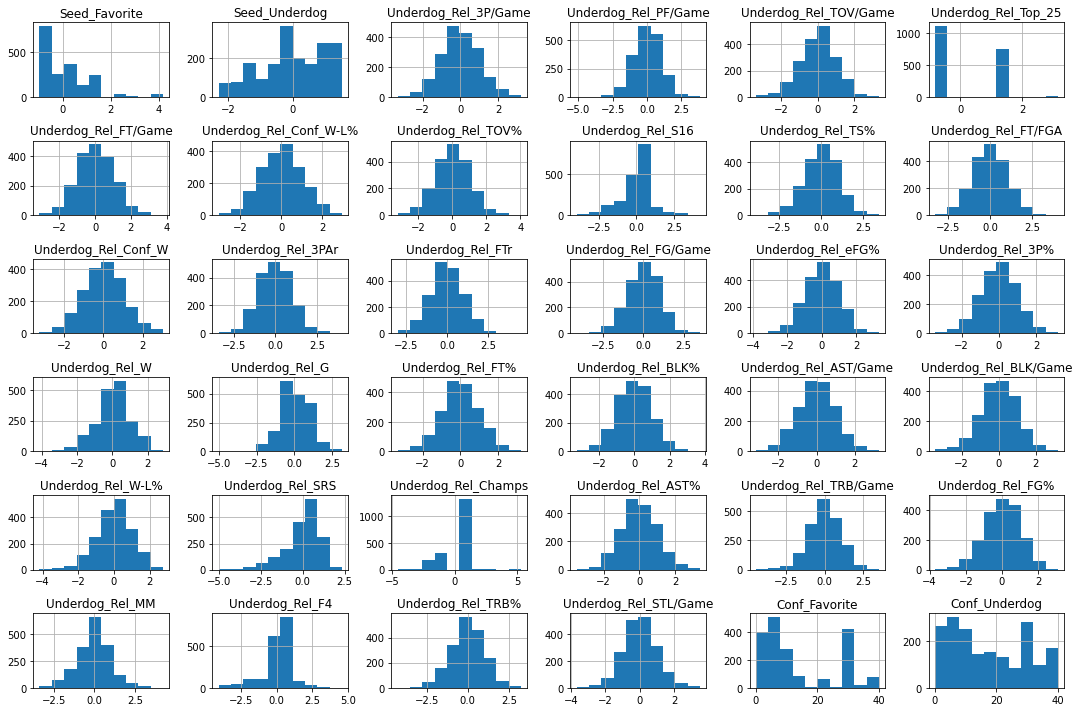

In [20]:
prep_all_X.hist(figsize=(15, 10))
plt.tight_layout()

### What Features have the Greatest Predictive Power?
The plot below represents an important concept in data science & machine learning: normalized information gain. It's a ratio of how much predictive power can be attributed to each feature in a feature matrix; these values should sum to 1, or 100% of the predictive power.

We can see underdog relative games (Underdog_Rel_G) has a staggering lead over the remaining features - almost 25% of predictive power can be attributed to that one feature alone! This is sensible because it highlights how March Madness matchup favorites play more games together than their underdog opponents, which gives them more experience. This strong predictive power may negatively impact our predictions for this 2020-21 season because the COVID-19 pandemic messed up the schedules of many traditionally top-tier teams this year.

The remaining dominant features are equally sensible: strength of schedule (SOS; measures the caliber of their regular season opponents), win-loss % (W-L%; what was their regular season record), and point differential (PtsDiff; what was their average margin of victory/defeat).

No handles with labels found to put in legend.


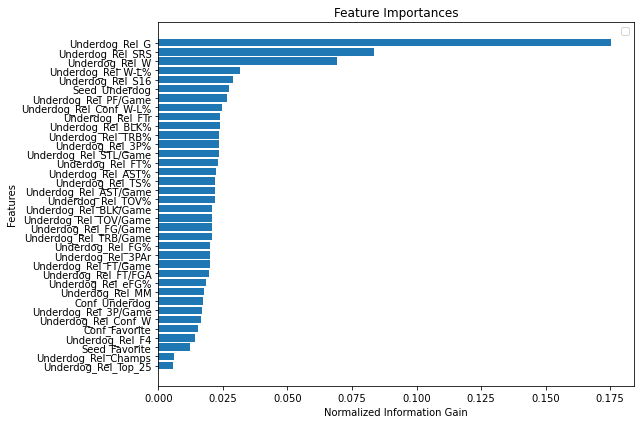

In [21]:
# Fit data to a Random Forest to find feature importances
rf = RandomForestClassifier().fit(prep_X_train, y_train)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = prep_all_X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

### What are the Correlations Between Features?

Though correlation differs from information gain, we still see the same features dominating the landscape. Even more interesting is that they're dominating to approximately the same degree that they were in our information gain plot above.

No handles with labels found to put in legend.


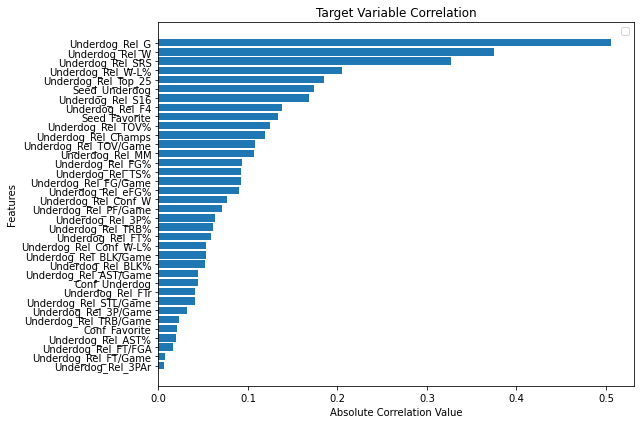

In [22]:
# Get feature matrix's correlations to target variable, then sort by absolute value
prep_X_y = prep_X_train.merge(y_train, left_index=True, right_index=True)
abs_desc_corr = np.abs(prep_X_y.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

# Model Selection

### Cross-Validation

1,814 total records in a dataset isn't much, so it was necessary to employ cross-validation (CV) on the training dataset to simulate the presence of a validation set. I saw from a quick online search that a 60%-20%-20% training-validation-test set split was ideal, which required me to perform 4 CVs in my grid and randomized searches.

*(Insert commentary about final model choice here)*

In [23]:
%%time

# Perform CV on chosen models with the training set, then assess their respective performances
cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, prep_X_train, y_train)
     
model_performance

Wall time: 2min 47s


,Best_Mean_Accuracy,Best_Mean_Accuracy_Std
Naive Bayes,0.705,0.016
LogReg,0.806,0.017
SVM,0.801,0.015
Random Forest,0.804,0.014
XGBoost,0.808,0.023


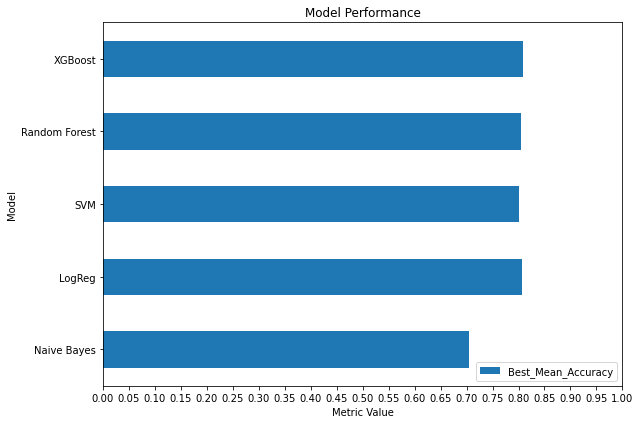

In [24]:
# Plot the performance of each model against the Accuracy metric
model_performance['Best_Mean_Accuracy'].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 1.01, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

In [25]:
# Identify best model to use
best_model = cv_models['Random Forest'][-1].best_estimator_
best_params = cv_models['Random Forest'][-1].best_params_

display(best_params)

{'random_state': 42,
 'n_estimators': 100,
 'min_samples_split': 16,
 'min_samples_leaf': 2,
 'criterion': 'entropy'}

# Model Evaluation

The distribution of the predicted upsets across the tournament rounds in our test set is very similar to the true target variable values we observed in our original dataset, with the primary differences being fewer first round upsets and more third round (Sweet 16) upsets than expected. The upsets by seed pairing also shows strong similarities to our original dataset's trends.

The confusion matrix at the end of this section allows us to see how this model performs in relation to precision (false positives; type I error) and recall (false negatives; type II error). Interestingly, the only metric that appears to be subpar is the recall for predicting an upset (when Underdog_Upset == 1). This suggests our model could be a little conversative and not pick upsets when it actually should, so that's important to keep in mind as we transition into making predictions for this year's March Madness matchups.

In [26]:
# Concatenate all visualization data into a single DataFrame
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)

# Overwrite the actual target variable (used for the join) with the best model's predictions
y_preds = model_predictions(best_model, prep_X_test)
test_game_data['Underdog_Upset'] = y_preds

# Get seed pairs data
test_seed_pairs = get_seed_pairs(test_game_data)
# Extract seed pairs that resulted in upsets
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]

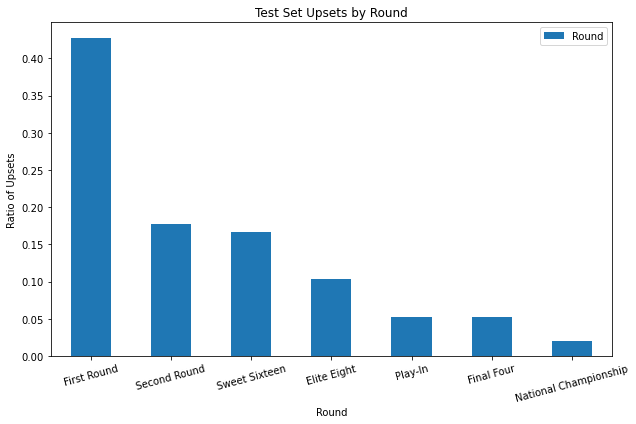

In [27]:
# Group upset seed pairs by round and count them
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

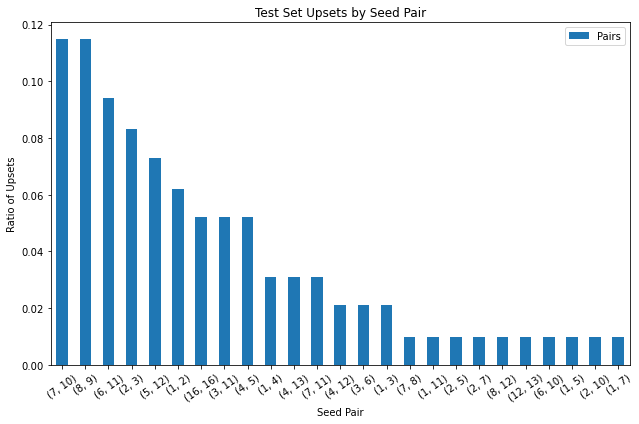

In [28]:
# Group upsets by seed pairing and count them
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

In [29]:
# Show confusion matrix for model's test set predictions
test_set_report = get_classification_report(y_test, y_preds)
print("Test Set Metrics Report \n\n", test_set_report)

Test Set Metrics Report 

               precision    recall  f1-score   support

           0       0.84      0.91      0.88       258
           1       0.77      0.63      0.69       118

    accuracy                           0.82       376
   macro avg       0.81      0.77      0.78       376
weighted avg       0.82      0.82      0.82       376



# 2022 March Madness Predictions

## Data Pipeline

We first scrape ESPN for the starting matchups in the play-in and the first round. We then automate the prediction of all rounds in the March Madness bracket. In short, the winners predicted from the first round (filled with predicted play-in winners) are reformatted to create matchups for the second round. Those second round winners are then reformatted into the third round, and so on and so forth until a champion is crowned.

Should you be curious about the more intricate details, you may refer to the bracket_pipeline() custom API documentation.

In [34]:
# Check if the starting bracket CSV exists, if it doesn't then create it
try:
    curr_bracket_df = pd.read_csv(f'{curr_year}_march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = fetch.get_current_bracket('http://www.espn.com/mens-college-basketball/bracket')
    curr_bracket_df.to_csv(f'{curr_year}_march_madness_curr_start_bracket.csv', index=False)

# Extract play-in matchups
play_in = curr_bracket_df[:4]

# Extract first round matchups
first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Southeast Missouri State,16,Texas A&M-Corpus Christi
1,11,Mississippi State,11,Pitt
2,11,Arizona State,11,Nevada
3,16,Fairleigh Dickinson,16,Texas Southern


,Seed,Team,Seed.1,Team.1
0,1,Alabama,16,Texas A&M Corpus Chris
1,8,Maryland,9,West Virginia
2,5,San Diego State.,12,College of Charleston
3,4,Virginia,13,Furman
4,6,Creighton,11,NC State
5,3,Baylor,14,UC Santa Barbara
6,7,Missouri,10,Utah State
7,2,Arizona,15,Princeton
8,1,Purdue,16,Fairleigh Dickinson
9,8,Memphis,9,Florida Atlantic


(None, None)

In [35]:
# Create DataFrame with all March Madness predictions
bracket_preds = bracket_pipeline(curr_year, play_in, first_round, best_model, data_cuts, null_drops)

# Display bracket_pipeline() predictions by round
for _round in bracket_preds['Round'].unique():
    display(bracket_preds[bracket_preds['Round'] == _round])

TypeError: cannot convert the series to <class 'float'>

## Pre-Tournament Model Evaluation (3/17/22)

The LogReg model predicted 25 upsets for the upcoming tournament, which is on the high end of the expected upsets distribution per our historical dataset EDA. This aggressiveness in upset prediction can be seen in how just as many upsets are predicted in the second round as in the first round, though based on historical trends a substantial dropoff in upsets with each successive round would be expected. This may result in the LogReg model producing a high number of false positives (resulting in low precision).

In [ ]:
# Get seed pairs data
curr_seed_pairs = get_seed_pairs(bracket_preds)
# Extract seed pairs that resulted in upsets
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

In [ ]:
# Group upset seed pairs by round and count them
curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
curr_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='Current Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')
print(f"Total Upsets: {len(curr_upset_pairs)}")

In [ ]:
# Group upsets by seed pairing and count them
curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()

# Plot findings
curr_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Current Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

## Post-Tournament Model Evaluation (9/22/22)

### True Tournament Outcomes EDA

It's incredibly pleasing to see the results of the true tournament outcomes given how closely they mirrored the observed patterns in the historical dataset EDA. Not only did the tournament have exactly 20 upsets, but the distributions of said upsets across the tournament rounds and seed pairings was comparable to what was observed in both the historical and test datasets.

In [33]:
basic_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/men/{curr_year}-school-stats.html",
                                     attrs={'id': 'basic_school_stats'})
clean_basic_stats_df = clean_basic_stats(basic_stats_df)

# Clean basic stats' school names to properly merge with raw tournament data
if clean_basic_stats_df['School'].str.contains('NCAA').any():
    clean_basic_stats_df['School'] = clean_basic_stats_df['School'].apply(lambda school: school[:-5])

clean_basic_stats_df['School'].replace(season_team_to_coach_team_dict, inplace=True)

# Create DataFrame with all March Madness outcomes
bracket_trues = clean_tourney_data(hist_bracket_df, clean_basic_stats_df)
create_bracket_winners(bracket_trues)

# Display true tournament results by round
for _round in bracket_trues['Round'].unique():
    display(bracket_trues[bracket_trues['Round'] == _round])

NameError: name 'hist_bracket_df' is not defined

In [ ]:
# Get seed pairs data
true_seed_pairs = get_seed_pairs(bracket_trues)
# Extract seed pairs that resulted in upsets
true_upset_pairs = true_seed_pairs[true_seed_pairs['Underdog_Upset'] == 1]

In [ ]:
# Group upset seed pairs by round and count them
true_upset_rounds_freq = true_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
true_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='True Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')
print(f"Total Upsets: {len(true_upset_pairs)}")

In [ ]:
# Group upsets by seed pairing and count them
true_upset_pairs_freq = true_upset_pairs['Pairs'].value_counts()

# Plot findings
true_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='True Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

### Compare Predicitons to True Outcomes

The LogReg model correctly predicted 40 of the 67 possible games, resulting in an accuracy of ~59.7%. Once again, the confusion matrix metrics for predicting an upset are inferior in comparison to predicting favorites' victories. However, in this case, it's the precision that bottoms out as the worst metric. This was expected given the aggressive predictive behavior observed in our LogReg pre-tournament model predictions (25 upsets predicted vs. 20 true upsets).

In [ ]:
# Reorder the tournament regions of the true outcomes to align with the predicted outcomes
# (Necessary only when predicted and true data are scraped from different sources)
ordered_bracket_trues = pd.concat([
    bracket_trues.iloc[[1, 0, 2, 3]],                                                                            # Play-In
    bracket_trues.iloc[49:57], bracket_trues.iloc[4:12], bracket_trues.iloc[34:42], bracket_trues.iloc[19:27],   # First Round
    bracket_trues.iloc[57:61], bracket_trues.iloc[12:16], bracket_trues.iloc[42:46], bracket_trues.iloc[27:31],  # Second Round
    bracket_trues.iloc[61:63], bracket_trues.iloc[16:18], bracket_trues.iloc[46:48], bracket_trues.iloc[31:33],  # Sweet 16
    bracket_trues.iloc[[63, 18, 48, 33]],                                                                        # Elite 8
    bracket_trues.iloc[[64, 65]],                                                                                # Final 4
    bracket_trues.iloc[[66]]                                                                                     # Championship
], ignore_index=True)
    

# Create a DataFrame that combines the tournament data predictions and true values
trues_preds = pd.DataFrame(data={
    'Round': ordered_bracket_trues['Round'],
    'Predicted Winner': bracket_preds['Winner'],
    'True Winner': ordered_bracket_trues['Winner'].replace(curr_season_to_tourney_dict)
})

display(trues_preds)

In [ ]:
# Create a DataFrame with the model's correct predictions
correct_preds = trues_preds[trues_preds['True Winner'] == trues_preds['Predicted Winner']]

# Calculate and output the model's accuracy
print(f"Accuracy: {np.round(len(correct_preds) / len(trues_preds), 3)}")

correct_preds

# Conclusion & Future Work

My machine learning approach (59.7% accuracy) isn't refined enough yet to outperform random guessing (68.7% accuracy), but I have some feature engineering and modeling ideas for improving performance:
- #### Conference Features
 - March Madness has tradtionally been dominated by a few powerhouse teams generally found in the ACC and Big Ten conferences. I believe allowing future models to learn this trend, as well as teams' records within these conferences, will improve model performance by offsetting the dominance of the Underdog_Rel_G feature.
- #### LogReg Probability Estimation
 - I chose the LogReg model over the SVM model during model evaluation because I believed its capability to produce probability estimations would be incredibly useful in tuning our model to avoid being overly aggressive (high false positive rate, low precision) and overly cautious (high false negative rate, low recall). I still believe this to be true, but I simply ran out of time to implement it prior to the tournament's start this year.
- #### Additional Model Evaluation
 - Though scikit-learn models can be effective, it appears the industry is moving towards the use of gradient-boosted trees and deep learning neural nets. Implementing these models using libraries such as XGBoost and tensorflow may aid in future performance.
 
Overall, I'm incredibly encouraged by the results of my first-ever March Madness Predictions machine learning project. The LogReg model performed decently despite COVID-19 disrupting the incredibly predictive trend discovered in the underdog relative games (Underdog_Rel_G) feature. As was mentioned above, many of the tournament's traditional powerhouses played significantly less games than normal this past season, which turned the value of Underdog_Rel_G's information gain agaisnt the model in its predictions. Hopefully this year is simply an outlier experience that can bolster the EDA and decision making of the project's future iterations.